In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr

In [2]:
mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snaps = uri.TimeSeries(snap)
snaps.read_iout_avail()
nout = snaps.iout_avail['iout']
gals1 = uhmi.HaloMaker.load(snap, galaxy=True, double_precision=dp)
gals2 = pklload("./database/01_nh_ghmatch.pickle")
hals = uhmi.HaloMaker.load(snap, galaxy=False, double_precision=dp)
LG = pklload(f"./database/11_LocalGroup.pickle")

In [22]:
LG[2]['neighbor']

array([(20, 6.33095335)], dtype=[('id', '<i4'), ('mratio', '<f8')])

In [3]:
bggs = None
for key in LG.keys():
    temp = LG[key]['BGG']
    bggs = temp if(bggs is None) else np.hstack((bggs, temp))

sats = None
for key in LG.keys():
    temp = LG[key]['sats']
    sats = temp if(sats is None) else np.hstack((sats, temp))

subs = None
for key in LG.keys():
    temp = LG[key]['subs']
    subs = temp if(subs is None) else np.hstack((subs, temp))

pairs = None
for key in LG.keys():
    temp = LG[key]['real']
    temp = temp[temp['state'] == 'pair']
    pairs = temp if(pairs is None) else np.hstack((pairs, temp))

In [4]:
len(LG.keys())

37

In [5]:
minmax(np.log10(sats['m']))

len799: min=6.024029528542465, mean=7.666506897908936, max=10.72366083370578


In [6]:
minmax(np.log10(subs['m']))

len2991: min=8.115680503198076, mean=8.806462249259615, max=12.944459073516127


# Mass function

## Just number

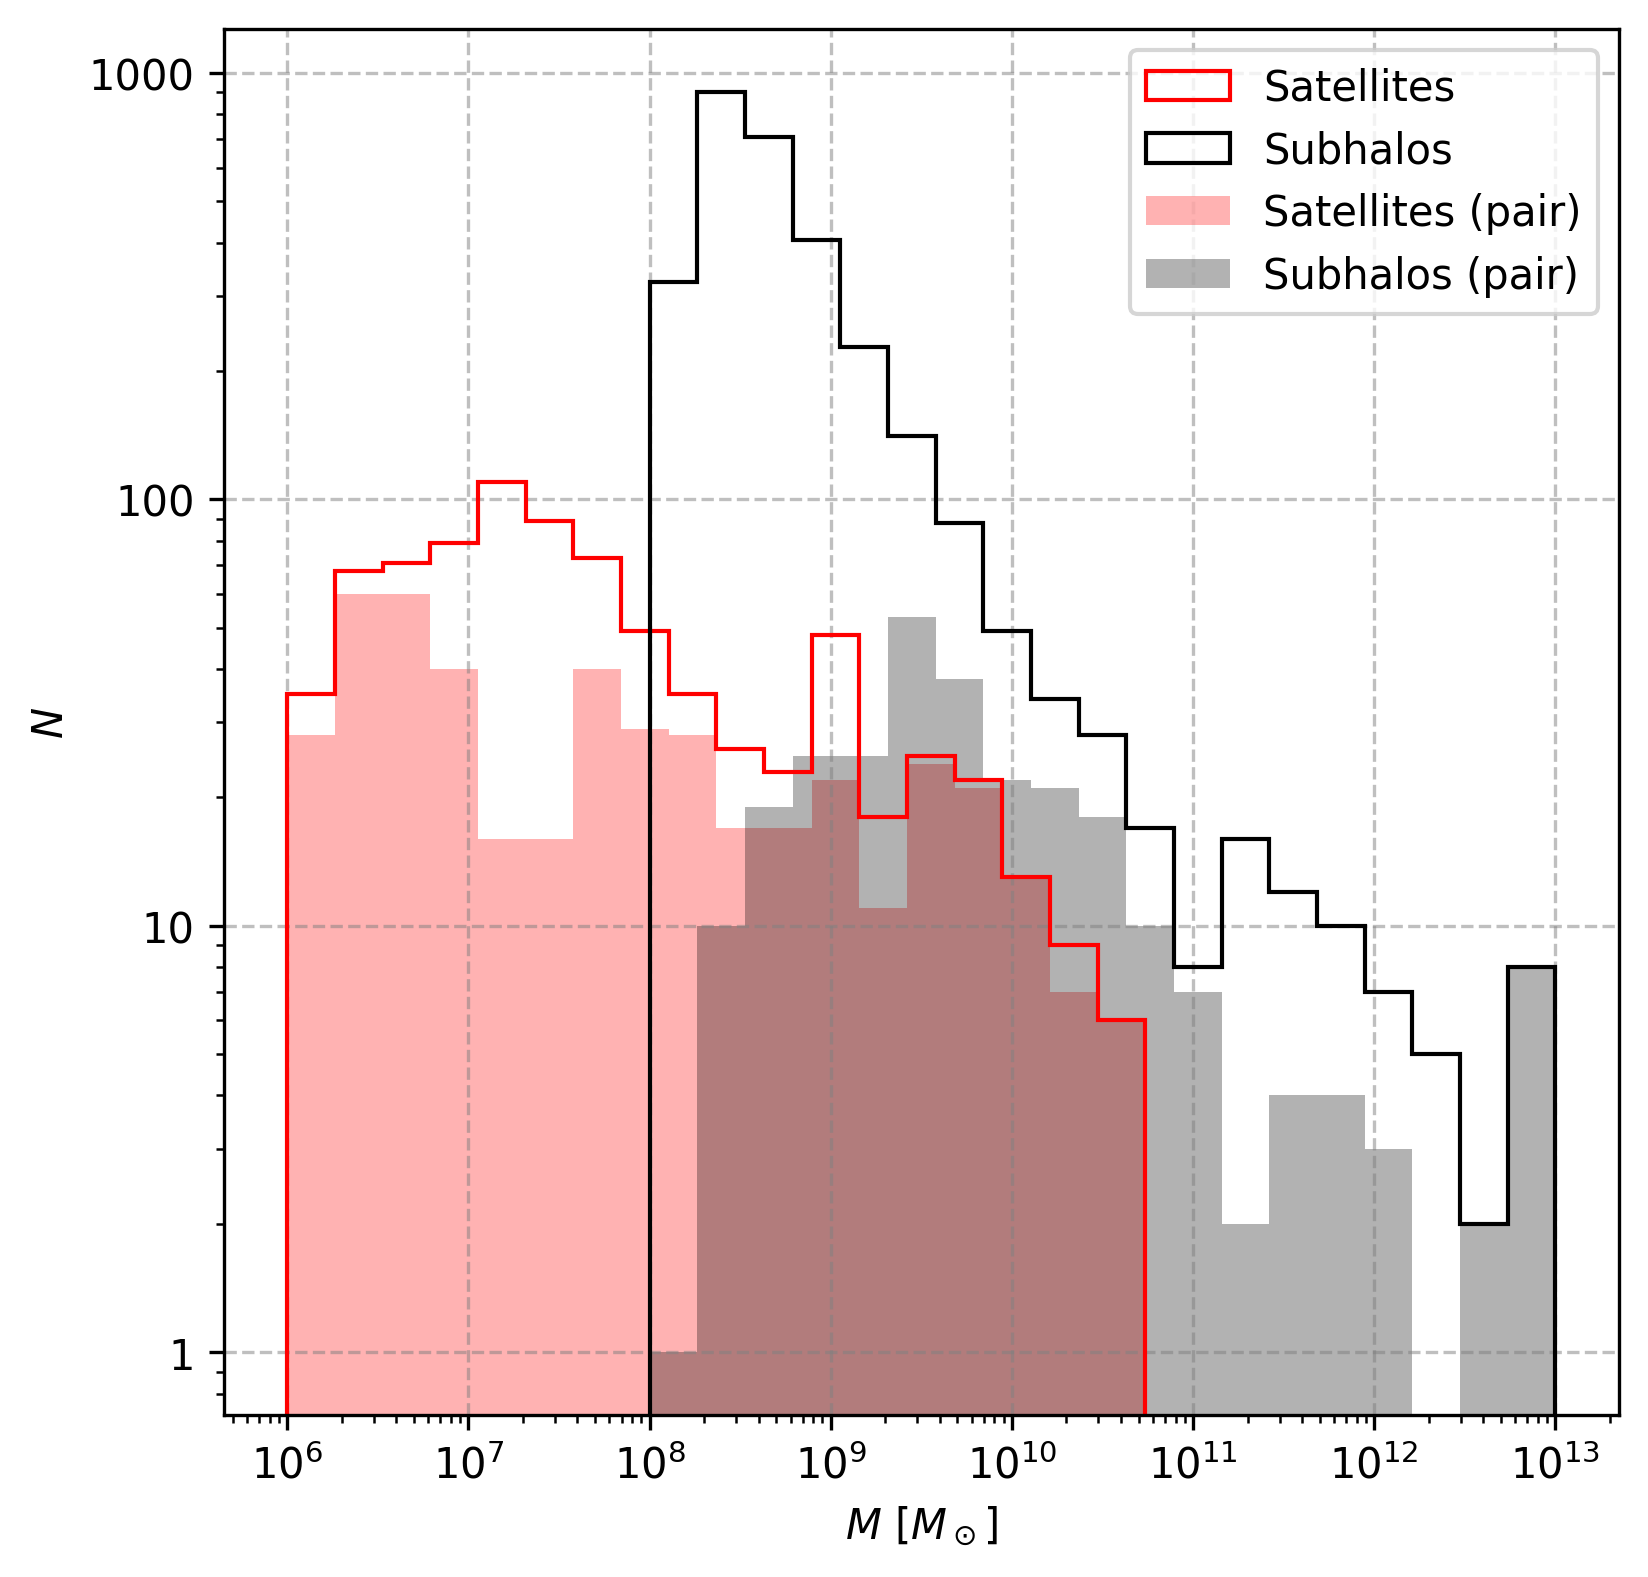

In [18]:
fig, ax = plt.subplots(dpi=300, figsize=(6, 6))

ax.grid(ls='--', c='gray', alpha=0.5)
ax.hist( sats['m'], bins=np.logspace(6,11,20), histtype='step', color='red', label='Satellites')
ax.hist( subs['m'], bins=np.logspace(8,13,20), histtype='step', color='k', label='Subhalos')
ind = isin(sats['id'], pairs['gid'])
ax.hist( sats['m'][ind], bins=np.logspace(6,11,20), histtype='stepfilled', color='red', alpha=0.3, label='Satellites (pair)')
ind = isin(subs['id'], pairs['hid'])
ax.hist( subs['m'][ind], bins=np.logspace(8,13,20), histtype='stepfilled', color='k', alpha=0.3, label='Subhalos (pair)')

ax.set_xscale('log')
ax.set_xlabel(r'$M\ [M_\odot]$')

ax.set_yscale('log')
ax.set_yticks([1, 10, 100, 1000])
ax.set_yticklabels([1, 10, 100, 1000])
ax.set_ylabel(r'$N$')


ax.legend()
plt.show()


# Number per group

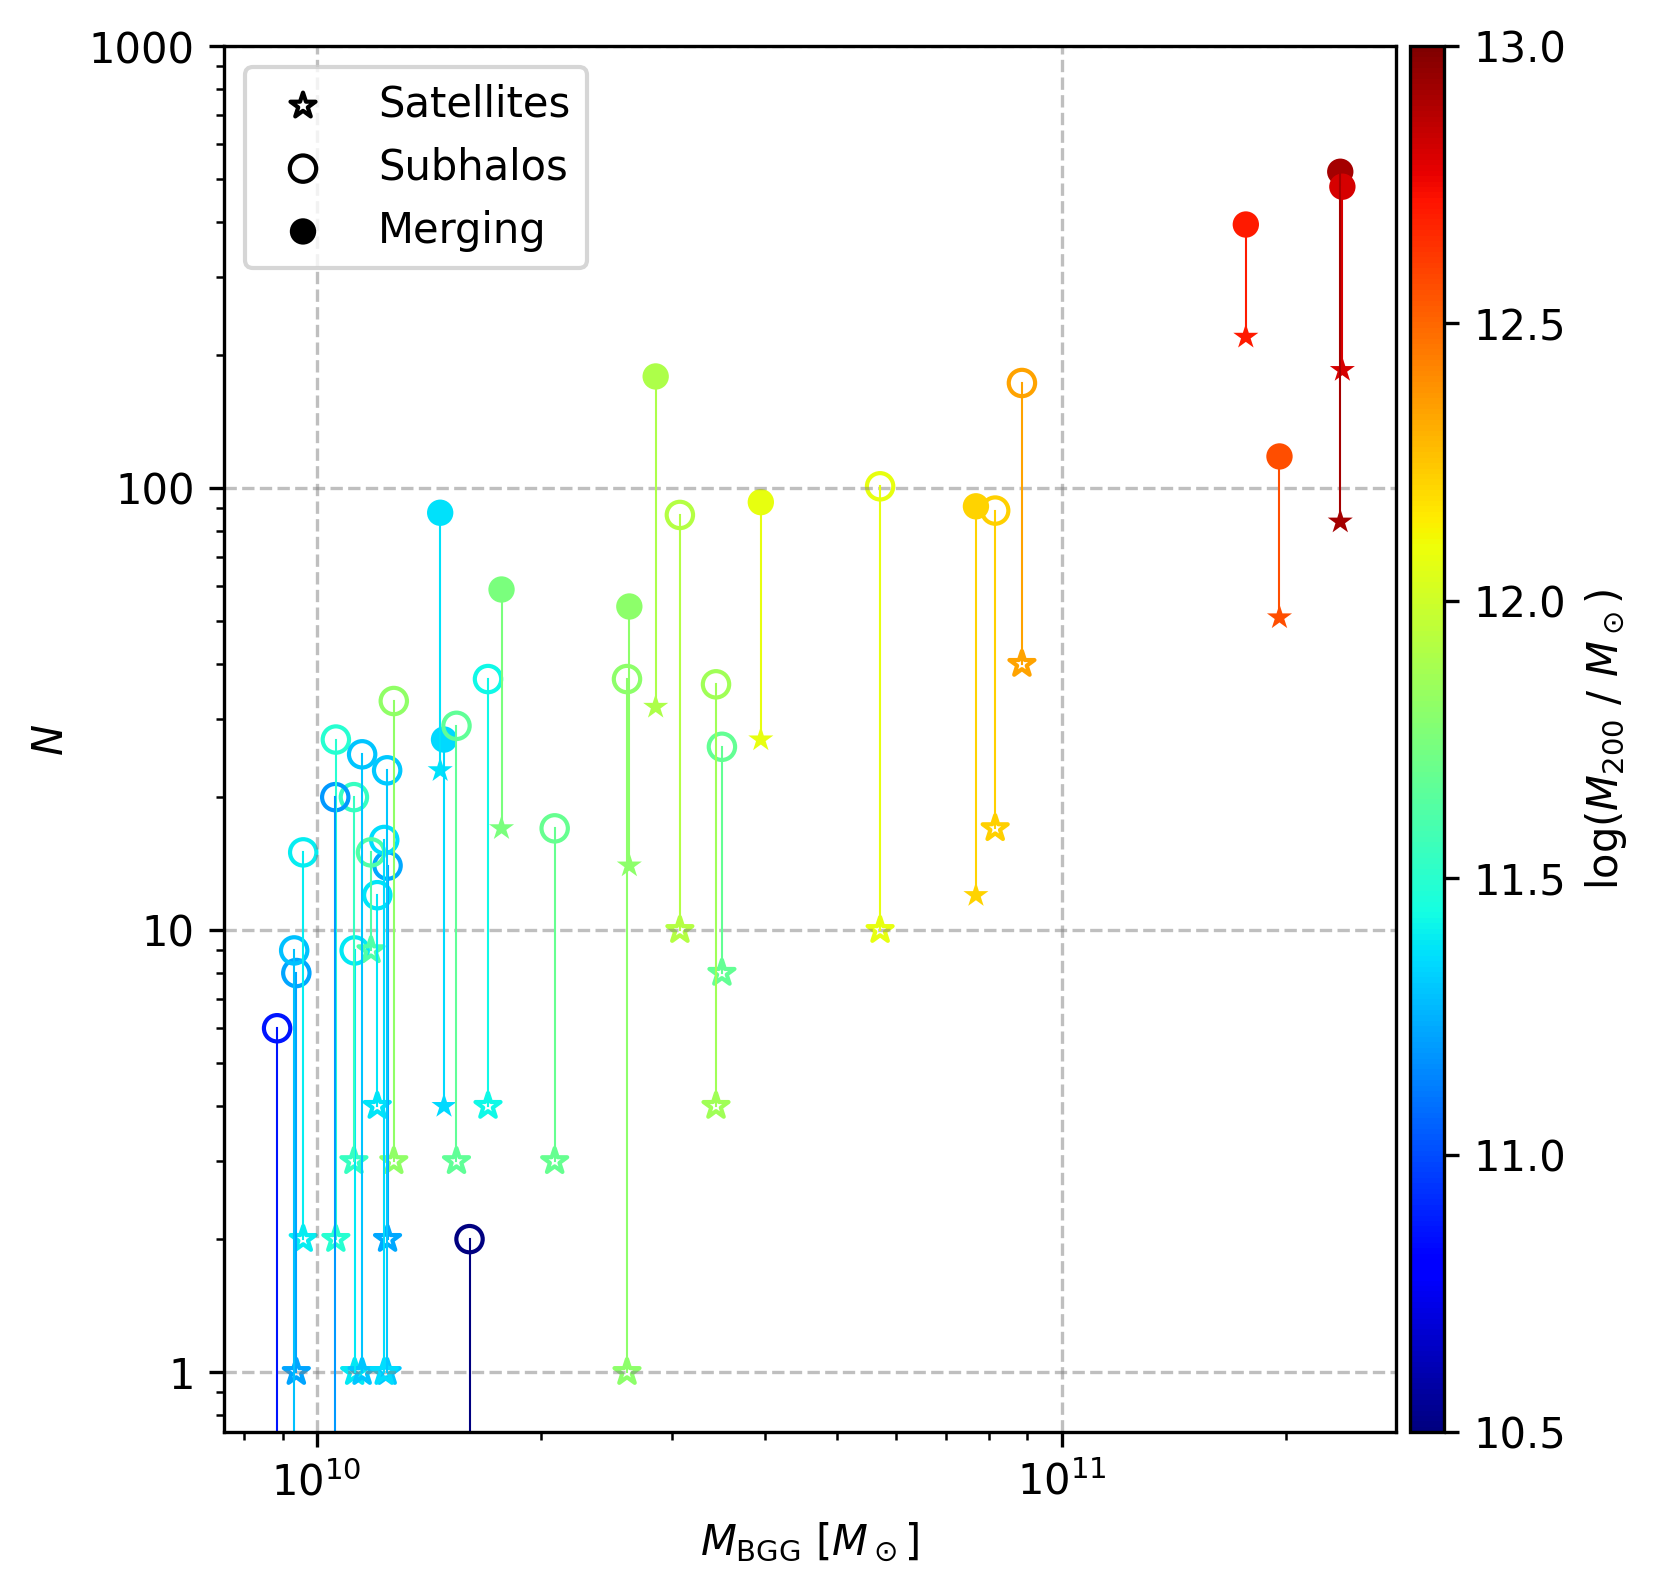

In [29]:
bins = np.logspace(9.5,11.5,5)

cmap = plt.cm.jet
norm = plt.Normalize(vmin=10.5, vmax=13)

fig, ax = plt.subplots(dpi=300, figsize=(6, 6))
ax.grid(ls='--', c='gray', alpha=0.5)

for i, bgg in enumerate(bggs):
    key = bgg['id']
    color = cmap(norm(np.log10(bgg['m200'])))
    nsats = len(LG[key]['sats'])
    nsubs = len(LG[key]['subs'])
    ckwargs = {'facecolor':color, 'edgecolor':'none'} if(len(LG[key]['neighbor'])>0) else {'facecolor':'none', 'edgecolor':color}
    ax.scatter( bgg['m'], nsats, marker='*', s=40, **ckwargs)
    ax.scatter( bgg['m'], nsubs, marker='o', s=40, **ckwargs)
    ax.plot( [bgg['m'], bgg['m']], [nsats, nsubs], color=color, lw=0.5)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.01, aspect=40)
cbar.set_label(r'$\log( M_{\rm 200}\ /\ M_\odot )$')

# Make legends ('satellites', 'subhalos')
ax.scatter( 0, 0, marker='*', edgecolor='k',facecolor='none',s=40, label='Satellites')
ax.scatter( 0, 0, marker='o', edgecolor='k',facecolor='none',s=40, label='Subhalos')
ax.scatter( 0, 0, marker='o', facecolor='k',edgecolor='none',s=40, label='Merging')
ax.legend()



ax.set_xscale('log')
ax.set_xlabel(r"$M_{\rm BGG}\ [M_\odot]$")
ax.set_yscale('log')
ax.set_ylabel(r"$N$")
ax.set_yticks([1, 10, 100, 1000])
ax.set_yticklabels([1, 10, 100, 1000])
ax.legend()

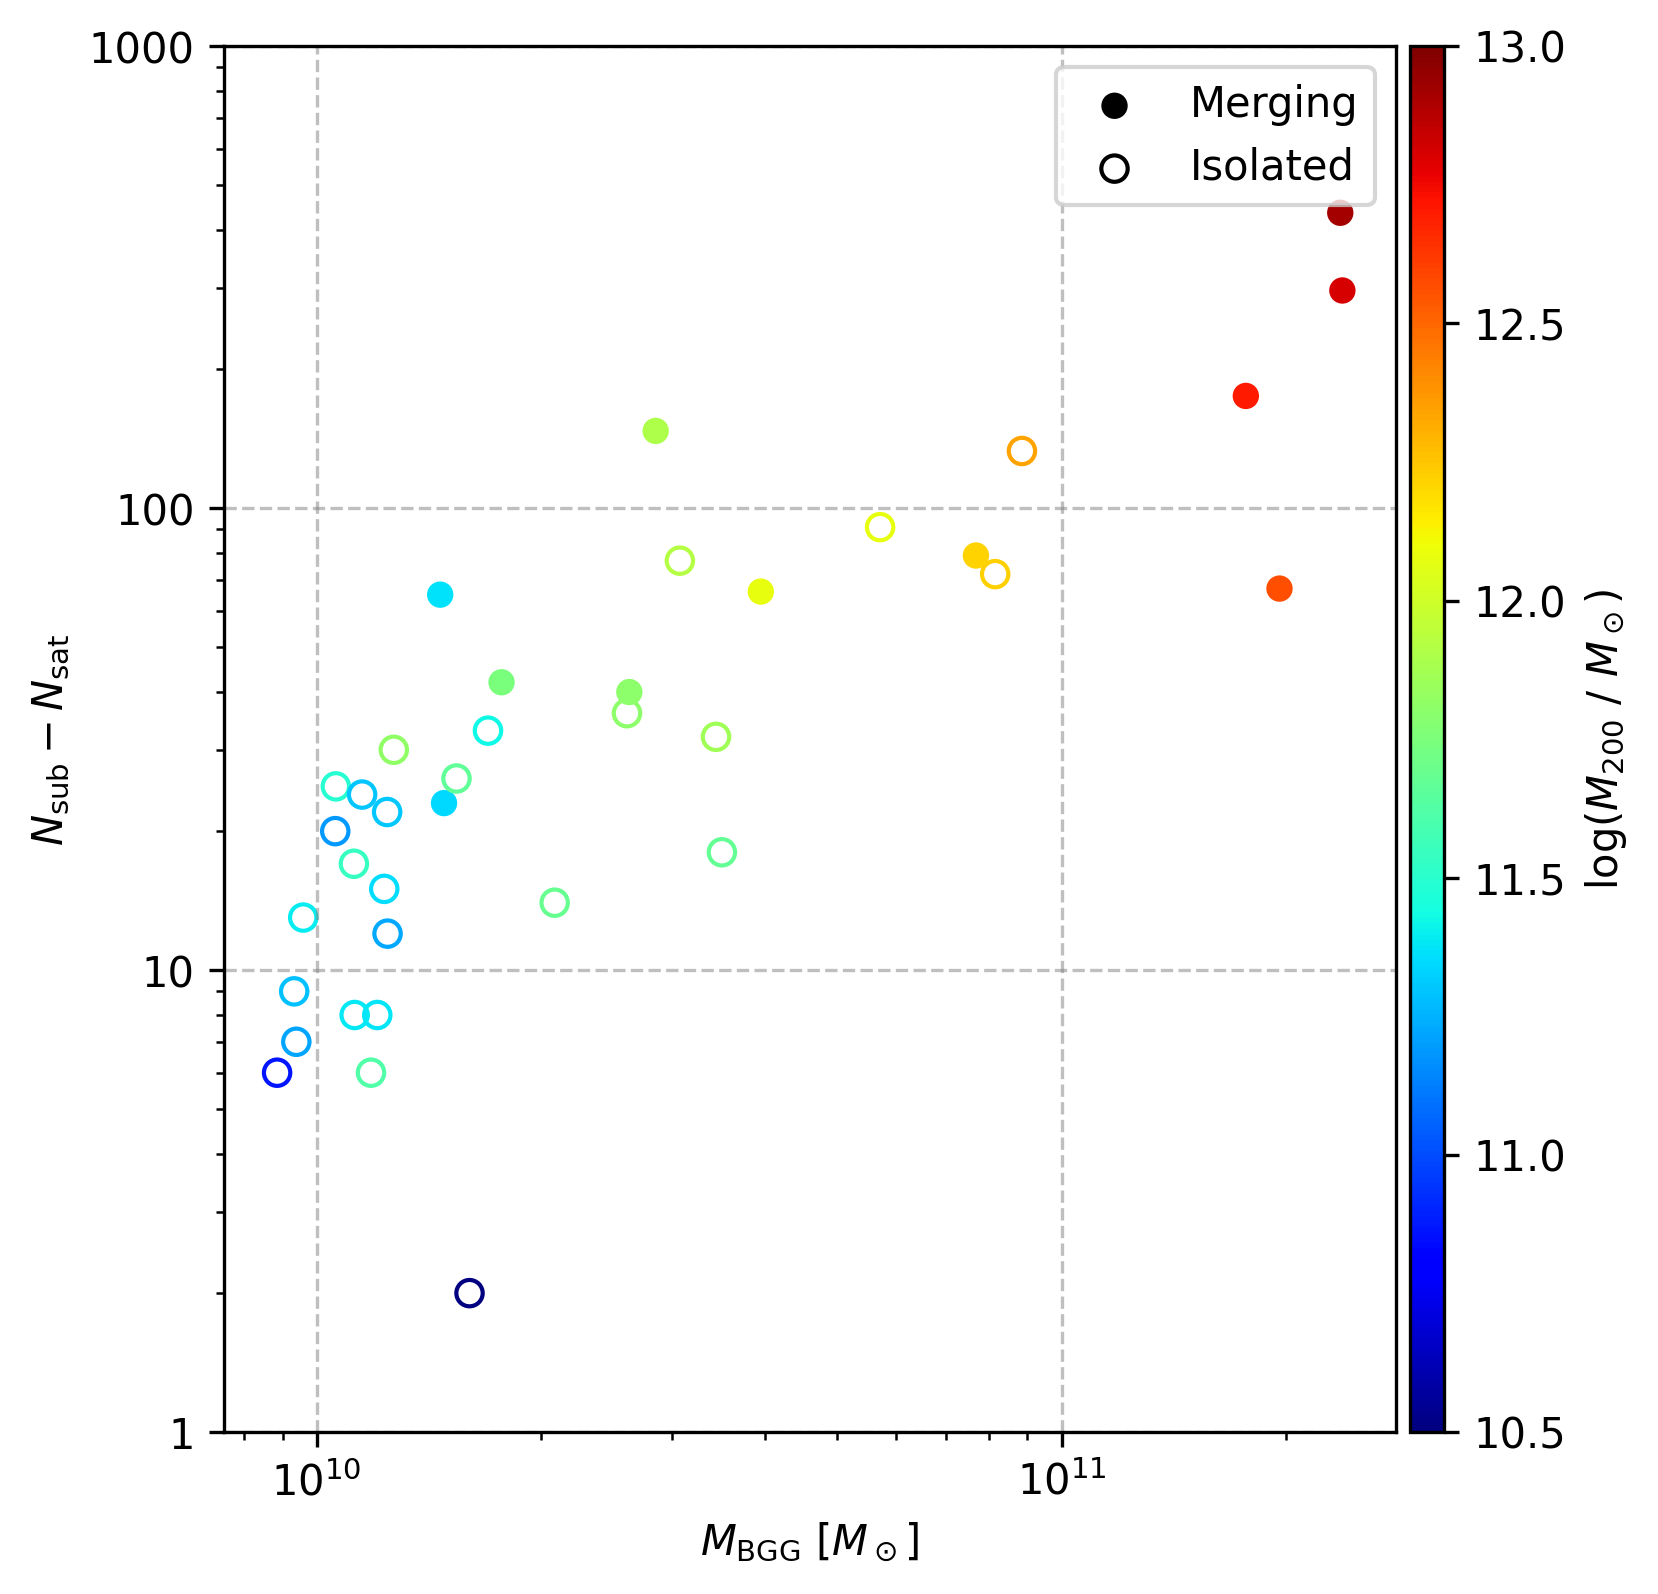

In [27]:
bins = np.logspace(9.5,11.5,5)

cmap = plt.cm.jet
norm = plt.Normalize(vmin=10.5, vmax=13)

fig, ax = plt.subplots(dpi=300, figsize=(6, 6))
ax.grid(ls='--', c='gray', alpha=0.5)

for i, bgg in enumerate(bggs):
    key = bgg['id']
    color = cmap(norm(np.log10(bgg['m200'])))
    nsats = len(LG[key]['sats'])
    nsubs = len(LG[key]['subs'])
    dn = nsubs - nsats
    # ax.scatter( bgg['m'], nsats, marker='*', color=color, s=40)
    if(len(LG[key]['neighbor'])==0):
        ax.scatter( bgg['m'], dn, marker='o', edgecolor=color, facecolor='none', s=40)
    else:
        ax.scatter( bgg['m'], dn, marker='o', facecolor=color, edgecolor='none', s=40)
    # print(key, len(LG[key]['neighbor']))
    # ax.plot( [bgg['m'], bgg['m']], [nsats, nsubs], color=color, lw=0.5)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.01, aspect=40)
cbar.set_label(r'$\log( M_{\rm 200}\ /\ M_\odot )$')

# Make legends ('satellites', 'subhalos')
ax.scatter( 0, 0, marker='o', facecolor='k', edgecolor='none',s=40, label='Merging')
ax.scatter( 0, 0, marker='o', edgecolor='k', facecolor='none', s=40, label='Isolated')
ax.legend()



ax.set_xscale('log')
ax.set_xlabel(r"$M_{\rm BGG}\ [M_\odot]$")
ax.set_yscale('log')
ax.set_ylabel(r"$N_{\rm sub} - N_{\rm sat}$")
ax.set_yticks([1, 10, 100, 1000])
ax.set_yticklabels([1, 10, 100, 1000])
ax.legend()

### Warning
I found satellites are omitted in pairs.

In [32]:
for key in LG.keys():
    satids = LG[key]['sats']['id']
    ind = isin(satids, LG[key]['real']['gid'])
    omitted = satids[~ind]
    if(len(omitted)>0):
        dtype = LG[key]['real'].dtype
        arr = np.zeros(len(omitted), dtype=dtype)
        arr['gid'] = omitted
        arr['state'] = 'orphan'
        LG[key]['real'] = np.hstack((LG[key]['real'], arr))

Pair, Orphan, Dink

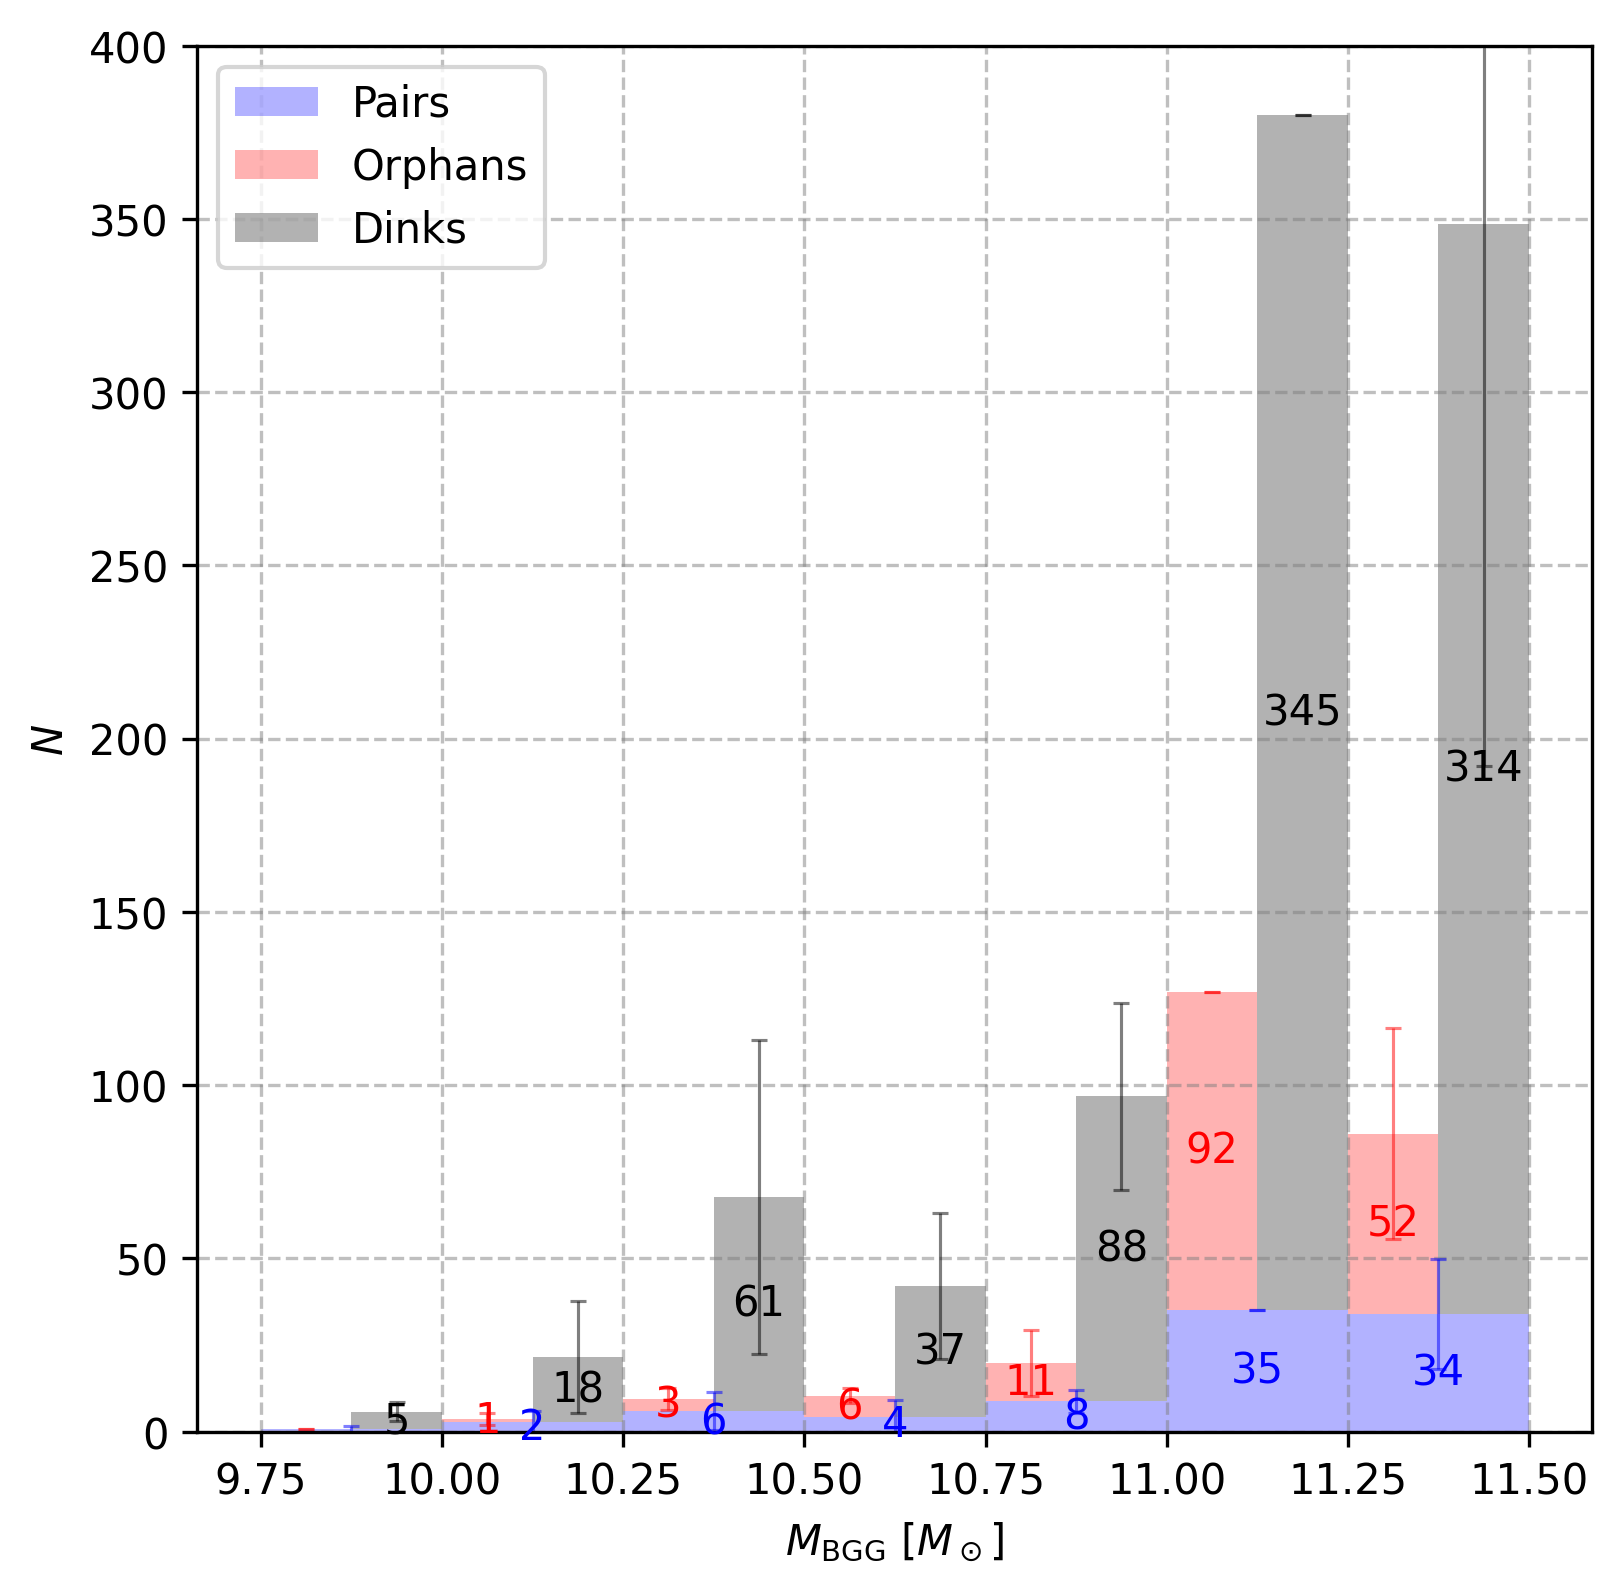

In [67]:
bins = np.linspace(9.5,11.5,9)
dff = bins[1]-bins[0]

fig, ax = plt.subplots(dpi=300, figsize=(6, 6))

ax.grid(ls='--', c='gray', alpha=0.5)
ekwargs = {'marker':'none','lw':0.75, 'capsize':2, 'elinewidth':0.75, 'capthick':0.75, 'alpha':0.5}
for i in range(len(bins)-1):
    temp = bggs[(bggs['m'] >= 10**bins[i])&(bggs['m'] < 10**bins[i+1])]
    npairs = np.zeros(len(temp))
    ndinks = np.zeros(len(temp))
    norphs = np.zeros(len(temp))
    for j,it in enumerate(temp):
        key = it['id']
        npairs[j] = np.sum(LG[key]['real']['state']=='pair')
        ndinks[j] = np.sum(LG[key]['real']['state']=='dink')
        norphs[j] = np.sum(LG[key]['real']['state']=='orphan')
    bottom=0
    ax.bar( 0.5*(bins[i]+bins[i+1]), np.mean(npairs), width=dff,edgecolor='none',facecolor='b',alpha=0.3,bottom=bottom, label='Pairs' if(i==0) else None, lw=0.5); bottom += np.mean(npairs)
    ax.errorbar(0.5*(bins[i]+bins[i+1]), bottom, np.std(npairs), color='b', **ekwargs)
    if(np.mean(npairs)>=1): ax.text( 0.5*(bins[i]+bins[i+1]), bottom-np.mean(npairs)/2, f"{int(np.mean(npairs))}", ha='center', va='center',color='b' )
    ax.bar( 0.5*(bins[i]+bins[i+1])-dff/4, np.mean(norphs), width=dff/2,edgecolor='none',facecolor='r',alpha=0.3,bottom=bottom, label='Orphans' if(i==0) else None)#; bottom += np.mean(norphs)
    ax.errorbar(0.5*(bins[i]+bins[i+1])-dff/4, bottom+np.mean(norphs), np.std(norphs), color='r', **ekwargs)
    if(np.mean(norphs)>=1): ax.text( 0.5*(bins[i]+bins[i+1])-dff/4, bottom+np.mean(norphs)/2, f"{int(np.mean(norphs))}", ha='center', va='center',color='r' )
    ax.bar( 0.5*(bins[i]+bins[i+1])+dff/4, np.mean(ndinks), width=dff/2,edgecolor='none',facecolor='k',alpha=0.3,bottom=bottom, label='Dinks' if(i==0) else None, lw=0.5)#; bottom += np.mean(ndinks)
    ax.errorbar(0.5*(bins[i]+bins[i+1])+dff/4, bottom+np.mean(ndinks), np.std(ndinks), color='k', **ekwargs)
    if(np.mean(ndinks)>=1): ax.text( 0.5*(bins[i]+bins[i+1])+dff/4, bottom+np.mean(ndinks)/2, f"{int(np.mean(ndinks))}", ha='center', va='center',color='k' )


ax.set_xlabel(r"$M_{\rm BGG}\ [M_\odot]$")
ax.set_ylabel(r"$N$")
ax.set_ylim(0,400)
ax.legend(loc='upper left')

In [108]:
pairs

array([(20795,  178, 'pair'), (20781,  220, 'pair'),
       (20716,  575, 'pair'), (20820, 1115, 'pair'),
       ( 1417,    2, 'pair'), (22200,   12, 'pair'),
       (22161,   20, 'pair'), (22265,   49, 'pair'),
       (22211,   51, 'pair'), (22129,   57, 'pair'),
       (22255,   61, 'pair'), (22033,   73, 'pair'),
       (21833,   74, 'pair'), (21868,   77, 'pair'),
       (22150,   79, 'pair'), (22054,   80, 'pair'),
       (21484,  114, 'pair'), (22175,  119, 'pair'),
       (22025,  153, 'pair'), (21768,  264, 'pair'),
       (21451,  300, 'pair'), (22253,  312, 'pair'),
       (22149,  315, 'pair'), (21737,  324, 'pair'),
       (22055,  373, 'pair'), (21913,  498, 'pair'),
       (21941,  499, 'pair'), (22192,  528, 'pair'),
       (22146,  550, 'pair'), (21822,  553, 'pair'),
       (21470,  576, 'pair'), (22021,  600, 'pair'),
       (21892,  620, 'pair'), (21932,  638, 'pair'),
       (22207,  675, 'pair'), (21915,  691, 'pair'),
       (21863,  704, 'pair'), (21230,  774, 'p

In [115]:
sats.dtype

dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('sigma_bulge', '<f8'), ('m_bulge', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('halo_id', '<i4'), ('halo_nparts', '<i4'), ('halo_level', '<i4'), ('halo_host', '<i4'), ('halo_hostsub', '<i4'), ('halo_x', '<f8'), ('halo_y', '<f8'), ('halo_z', '<f8'), ('halo_vx', '<f8'), ('halo_vy', '<f8'), ('halo_vz', '<f8'), ('halo_mvir', '<f8'), ('halo_rvir', '<f8'), ('fcontam', '<f8'), ('dist', '<f8'), ('central', '?'), ('main', '?'), ('Host', '<i4'), ('r50m', '<f8'), ('r90m', '<f8'), ('r50r

  0%|          | 0/264 [00:00<?, ?it/s]

100%|██████████| 264/264 [00:00<00:00, 460.33it/s]


Text(0.5, 0, '$M_{\\rm halo}\\ [M_\\odot]$')

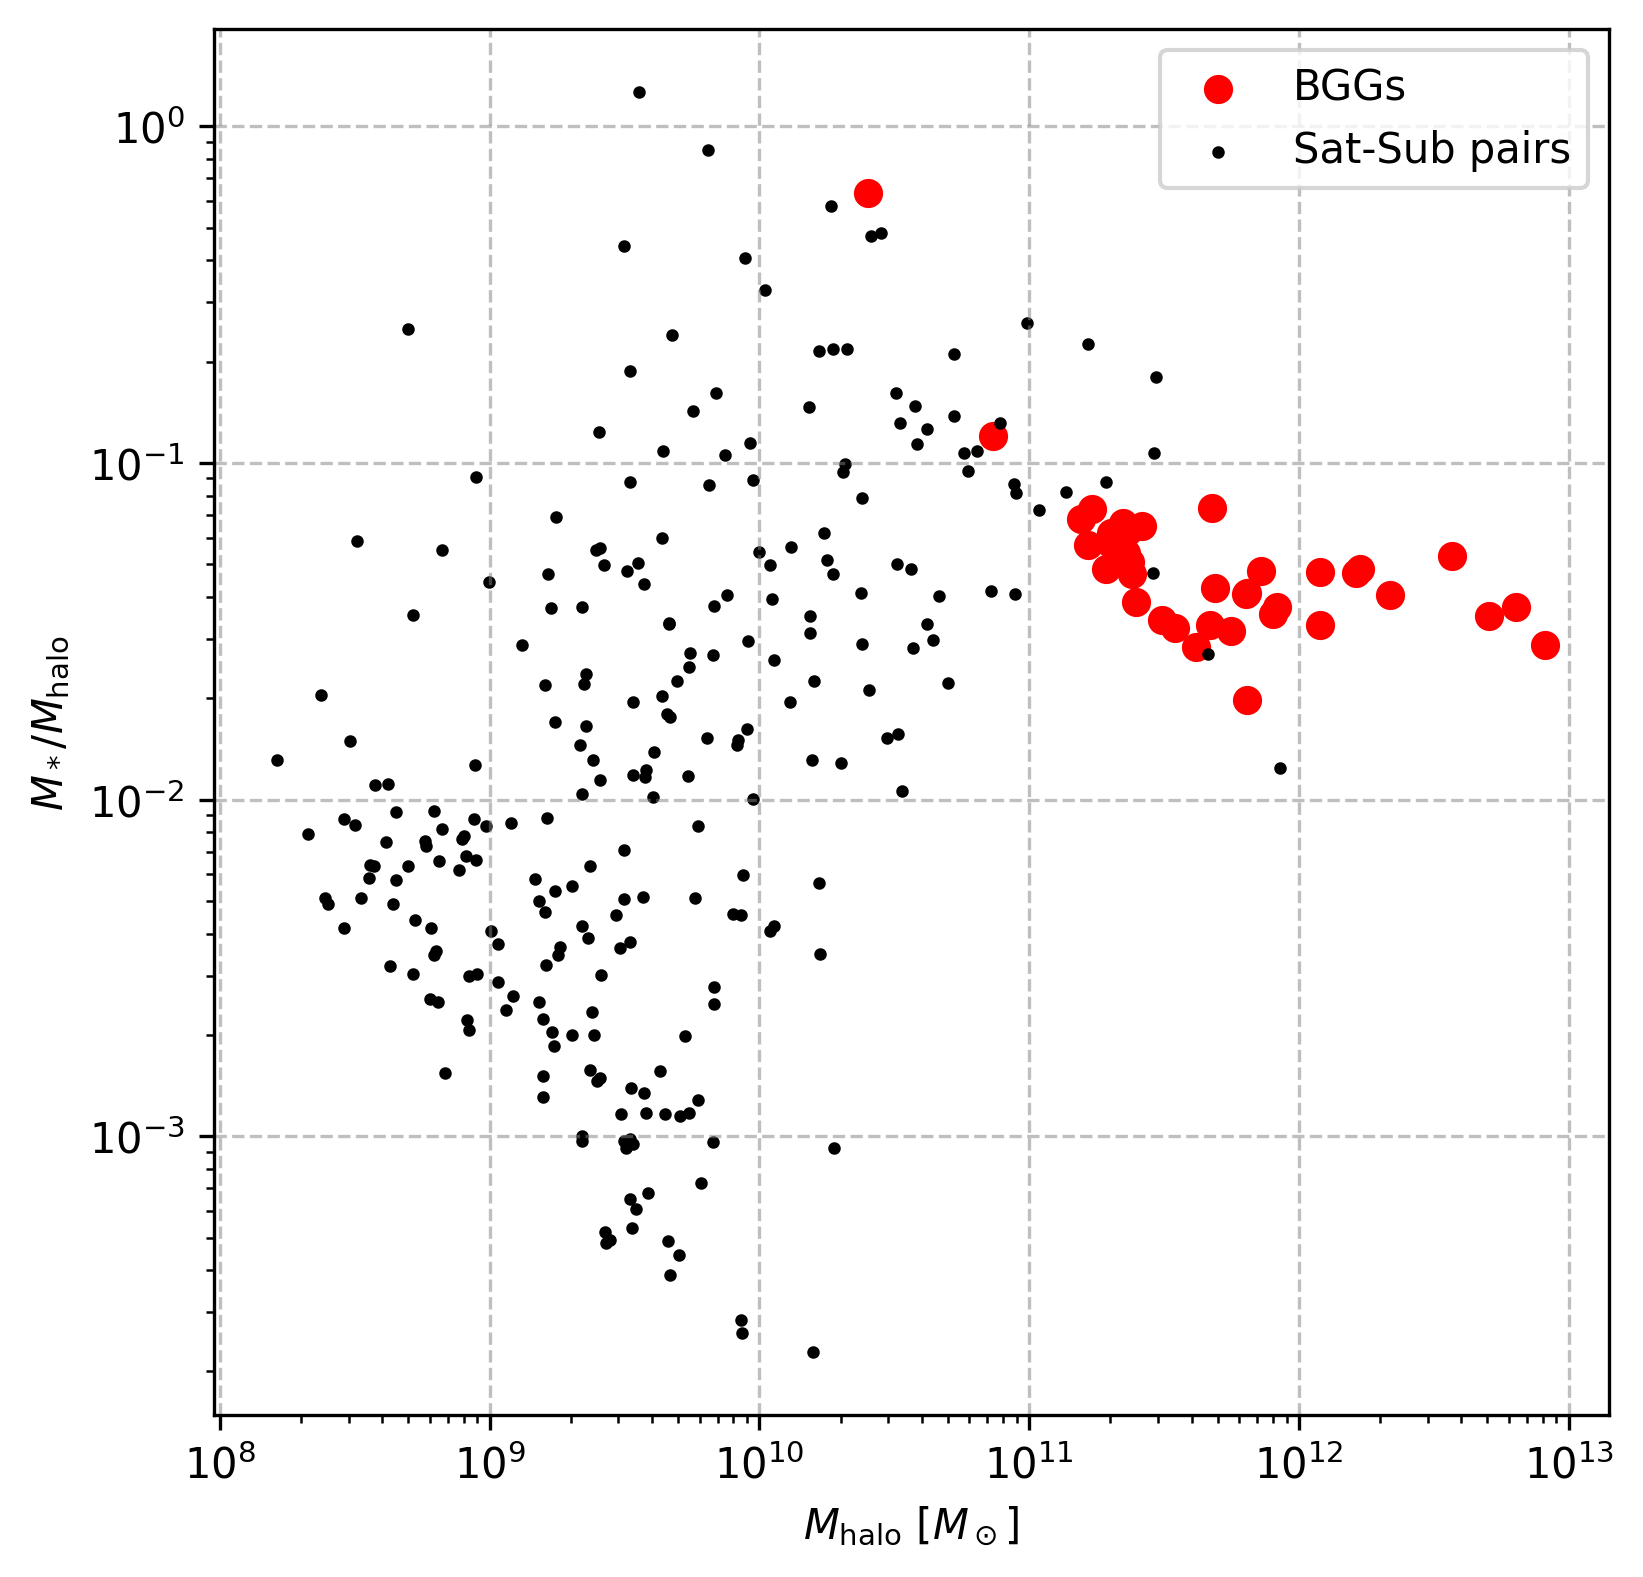

In [119]:
fig, ax = plt.subplots(dpi=300, figsize=(6, 6))
ax.grid(ls='--', c='gray', alpha=0.5)

ax.scatter(bggs['m200'], bggs['m']/bggs['m200'], color='r', label='BGGs')

count = 0
for pair in tqdm(pairs):
    try:
        isat = sats[sats['id'] == pair['gid']][0]
        isub = subs[subs['id'] == pair['hid']][0]
        ax.scatter(isub['m'], isat['m']/isub['m'], color='k', s=4, label='Sat-Sub pairs' if(count==0) else None)
        count += 1
    except:
        pass
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r"$M_{\rm *}/M_{\rm halo}$")
ax.set_xlabel(r"$M_{\rm halo}\ [M_\odot]$")

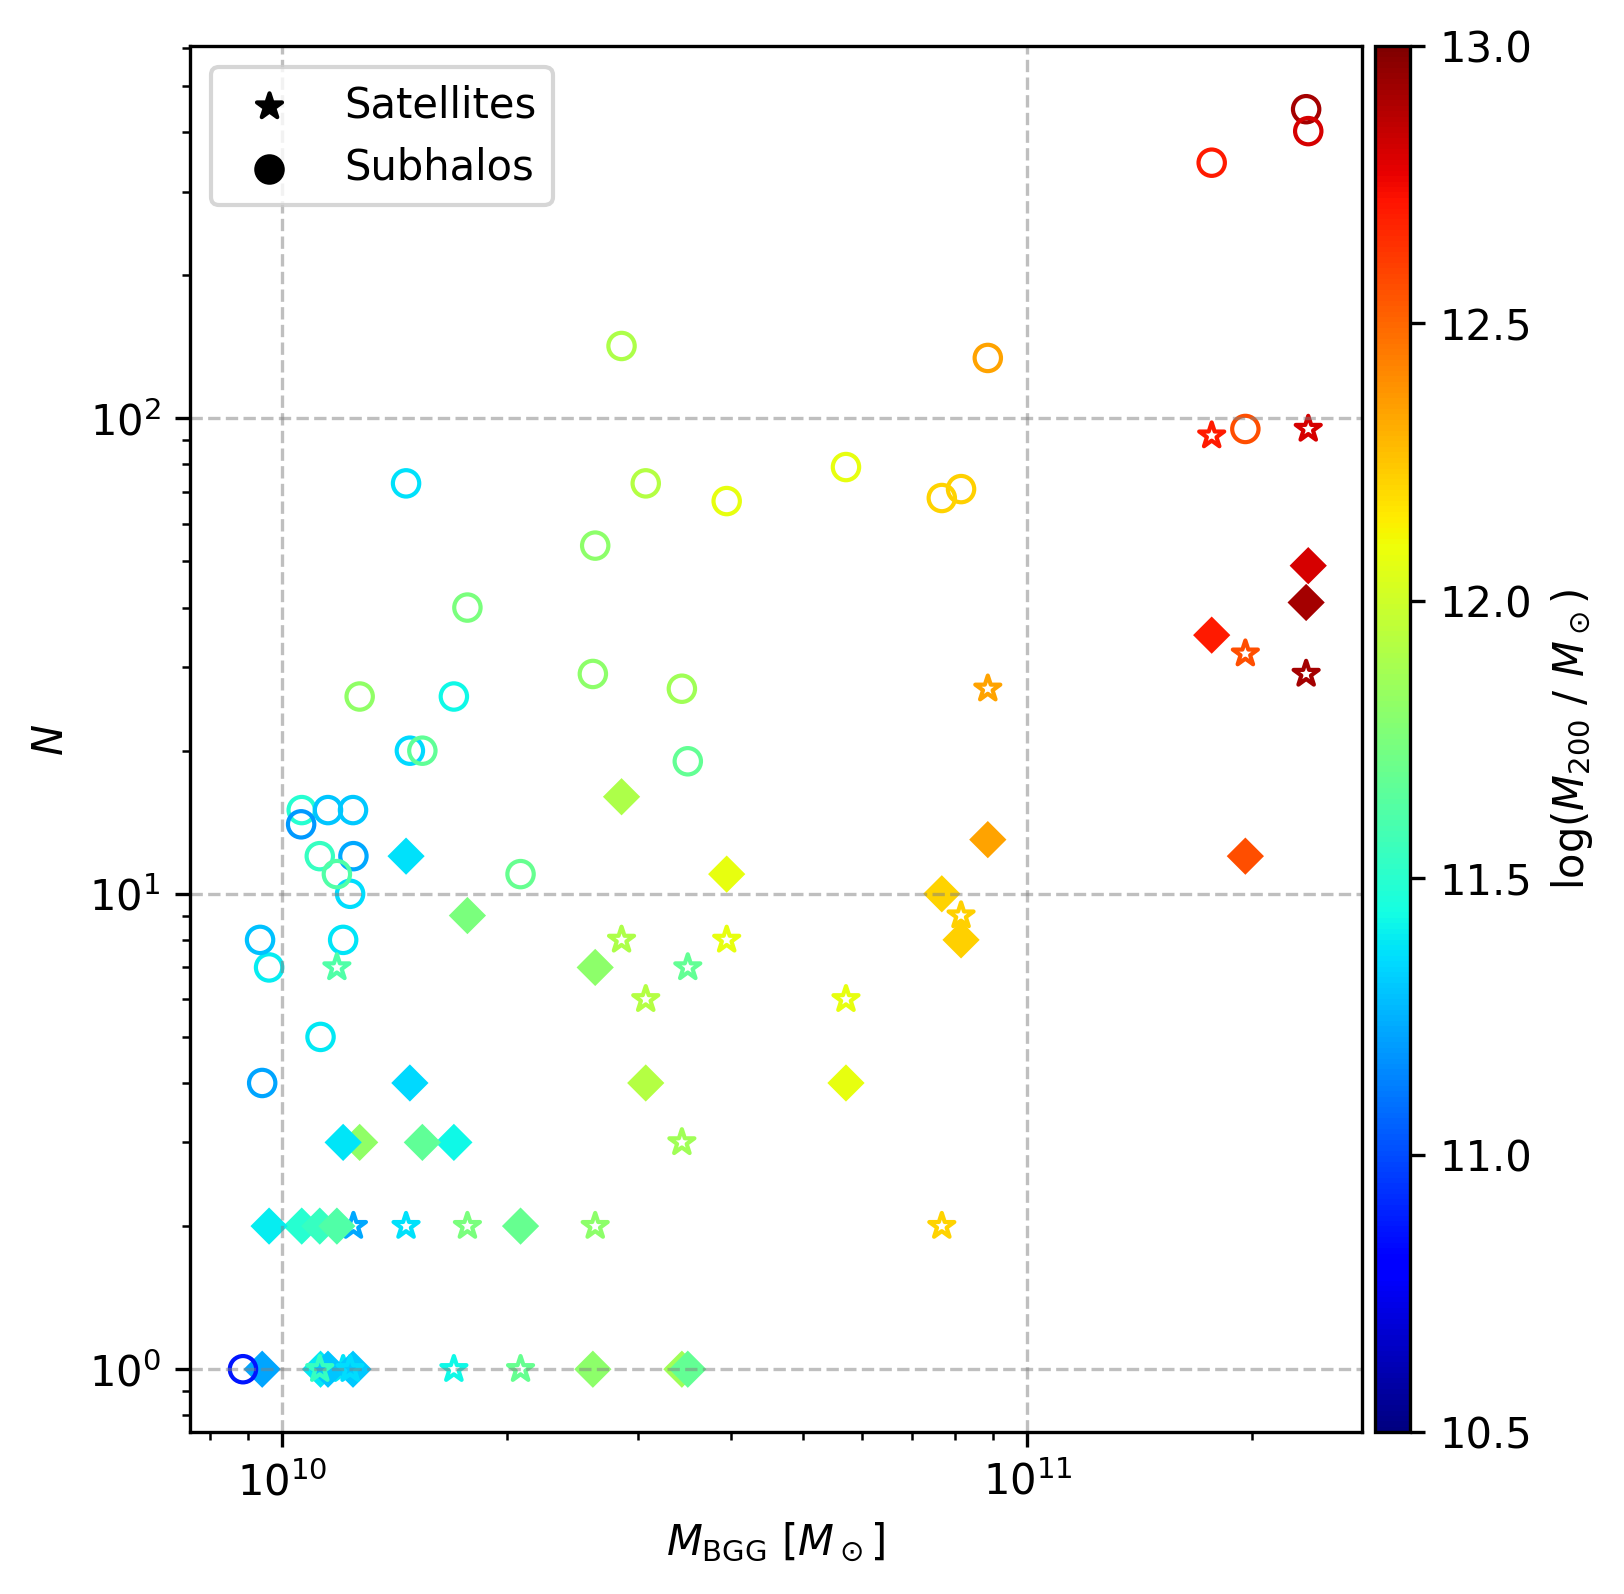

In [84]:
bins = np.logspace(9.5,11.5,5)

cmap = plt.cm.jet
norm = plt.Normalize(vmin=10.5, vmax=13)

fig, ax = plt.subplots(dpi=300, figsize=(6, 6))
ax.grid(ls='--', c='gray', alpha=0.5)

for i, bgg in enumerate(bggs):
    key = bgg['id']
    color = cmap(norm(np.log10(bgg['m200'])))

    npair = np.sum(LG[key]['real']['state']=='pair')
    ndink = np.sum(LG[key]['real']['state']=='dink')
    norphan = np.sum(LG[key]['real']['state']=='orphan')

    ax.scatter( bgg['m'], norphan, marker='*', edgecolor=color, s=40, facecolor='none')
    ax.scatter( bgg['m'], ndink, marker='o', edgecolor=color, s=40, facecolor='none')
    ax.scatter( bgg['m'], npair, marker='D', facecolor=color, s=40, edgecolor='none')
    # ax.plot( [bgg['m'], bgg['m']], [nsats, nsubs], color=color, lw=0.5)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.01, aspect=40)
cbar.set_label(r'$\log( M_{\rm 200}\ /\ M_\odot )$')

# Make legends ('satellites', 'subhalos')
ax.scatter( 0, 0, marker='*', color='k',s=40, label='Satellites')
ax.scatter( 0, 0, marker='o', color='k',s=40, label='Subhalos')
ax.legend()



ax.set_xscale('log')
ax.set_xlabel(r"$M_{\rm BGG}\ [M_\odot]$")
ax.set_yscale('log')
ax.set_ylabel(r"$N$")
ax.legend()

In [85]:
np.log10(bggs['m'])

array([10.75643354, 11.37415708, 10.2482527 , 11.37698195, 10.59630796,
       10.91091405, 11.29256528, 10.88508097, 10.41980467, 11.2473851 ,
       10.02584537, 10.53615015, 10.17102873, 10.94682808, 10.4166595 ,
       10.10361457, 10.09523384, 10.45516479, 10.08144207,  9.97276633,
       10.16589257, 10.05108835, 10.06110024, 10.05007495, 10.48764827,
        9.98201578, 10.02502987, 10.23007916, 10.09468647, 10.09079022,
       10.54409223, 10.18777623,  9.94696081, 10.319583  ,  9.96989501,
       10.07303044, 10.20526594])

In [86]:
minmax(np.log10(bggs['m']))

len37: min=9.946960812713854, mean=10.38912503536831, max=11.376981951471892


# Size-Mass

Text(0, 0.5, '$R_{\\rm 50}\\ [kpc]$')

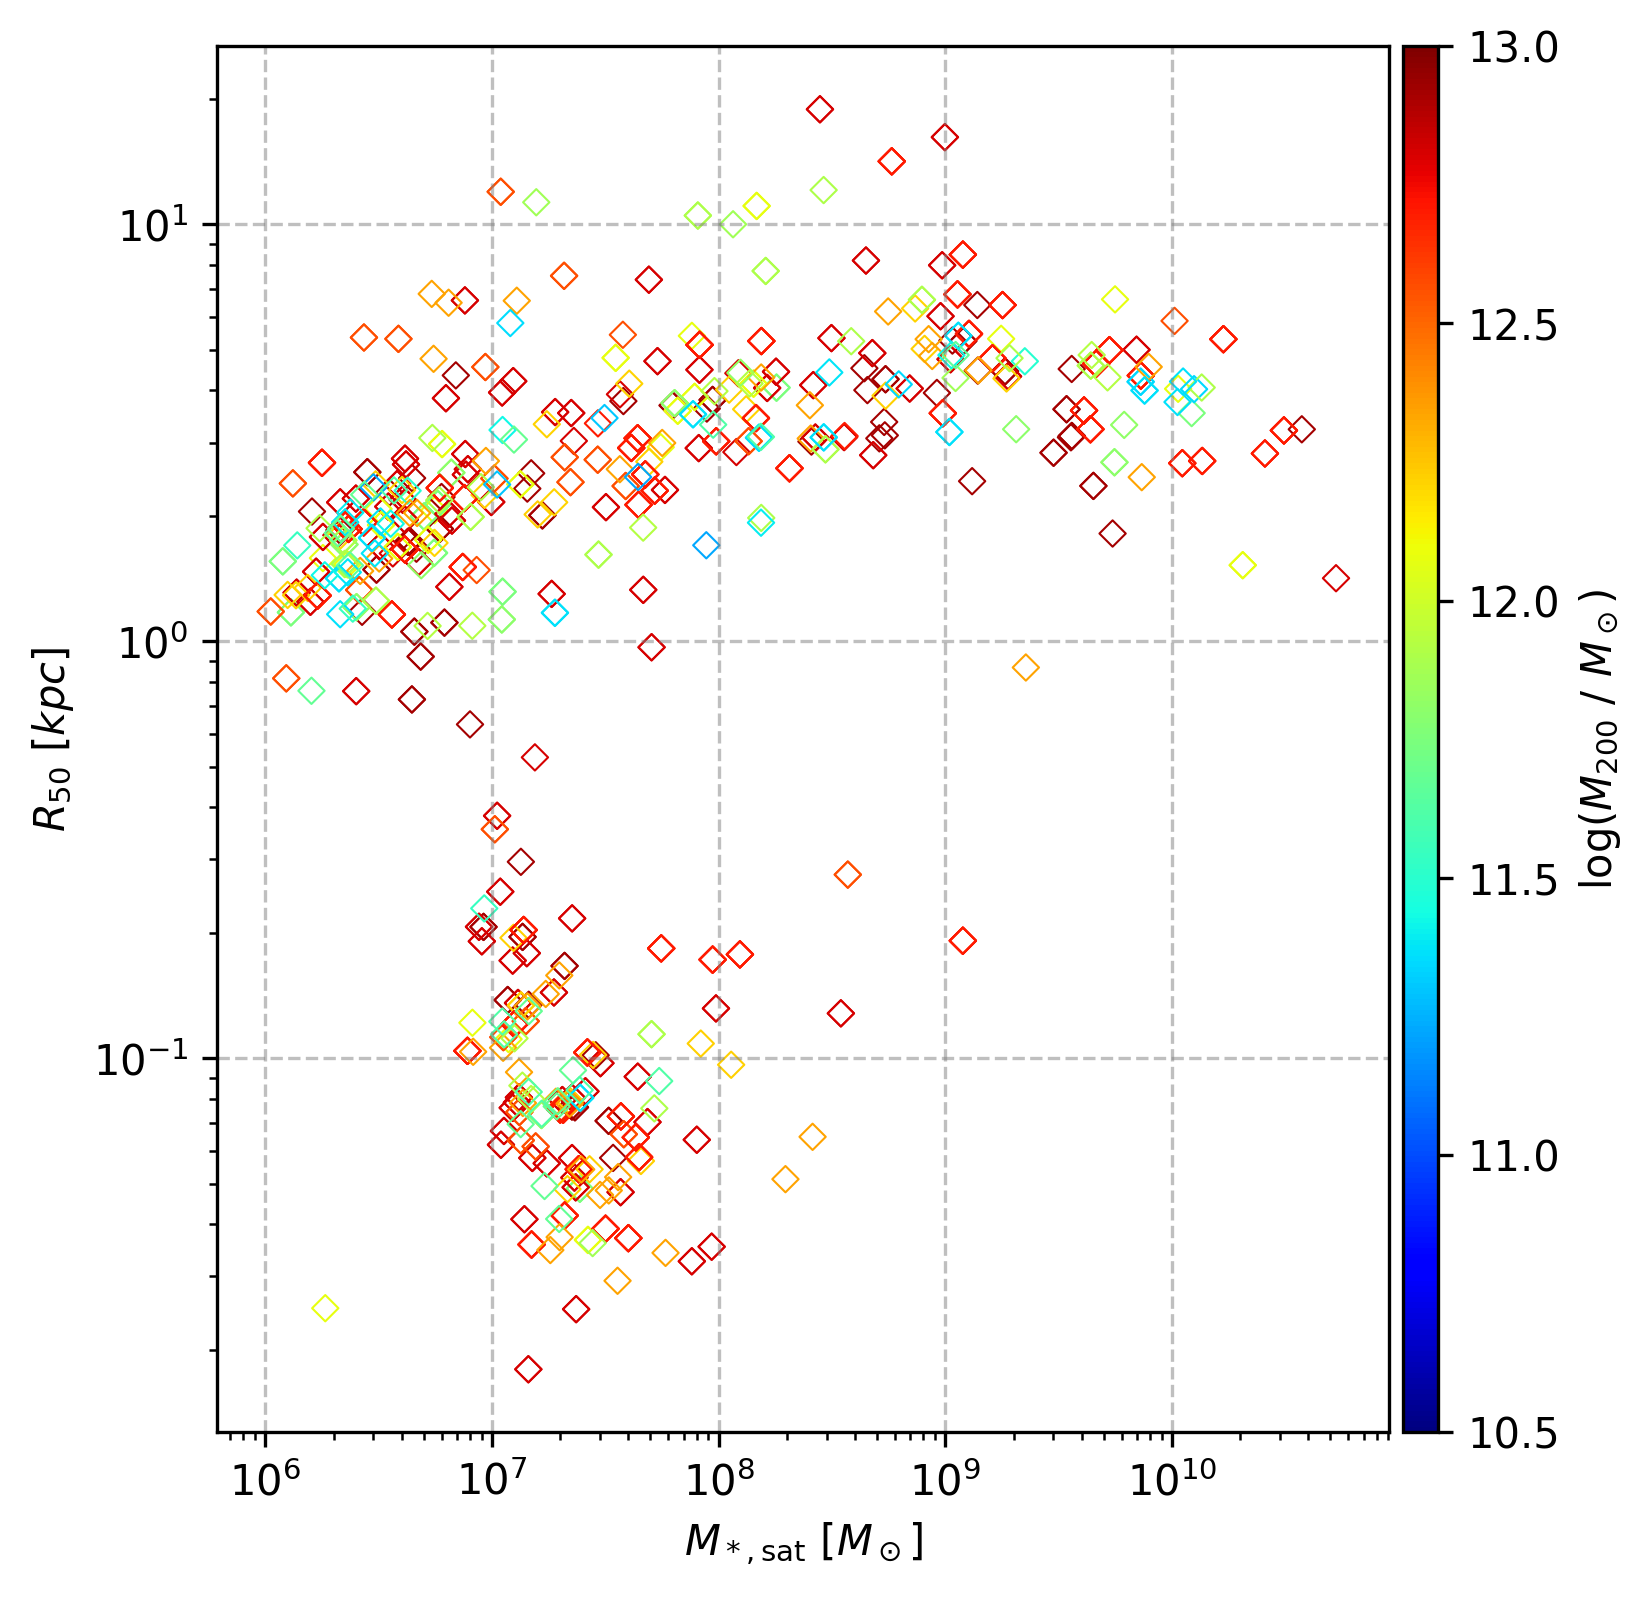

In [87]:
cmap = plt.cm.jet
norm = plt.Normalize(vmin=10.5, vmax=13)

fig, ax = plt.subplots(dpi=300, figsize=(6, 6))

ax.grid(ls='--', c='gray', alpha=0.5)
for key in LG.keys():
    group = LG[key]
    BGG = group['BGG']
    isats = group['sats']
    ax.scatter(
        isats['m'], isats['r50m']/snap.unit['kpc'],
        marker='D', s=20,
        facecolor='none', edgecolor=cmap(norm(np.log10(BGG['m200']))),
        lw=0.5)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.01, aspect=40)
cbar.set_label(r'$\log( M_{\rm 200}\ /\ M_\odot )$')


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M_{\rm *,sat}\ [M_\odot]$')
ax.set_ylabel(r'$R_{\rm 50}\ [kpc]$')

In [99]:
sats.dtype

dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('sigma_bulge', '<f8'), ('m_bulge', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('halo_id', '<i4'), ('halo_nparts', '<i4'), ('halo_level', '<i4'), ('halo_host', '<i4'), ('halo_hostsub', '<i4'), ('halo_x', '<f8'), ('halo_y', '<f8'), ('halo_z', '<f8'), ('halo_vx', '<f8'), ('halo_vy', '<f8'), ('halo_vz', '<f8'), ('halo_mvir', '<f8'), ('halo_rvir', '<f8'), ('fcontam', '<f8'), ('dist', '<f8'), ('central', '?'), ('main', '?'), ('Host', '<i4'), ('r50m', '<f8'), ('r90m', '<f8'), ('r50r

In [101]:
minmax(-2.5*np.log10(sats['r_r50r']))

len799: min=-20.742974286826854, mean=-13.157160820930269, max=-8.62200985071981


Text(0, 0.5, '$R_{\\rm eff}\\ [kpc]$')

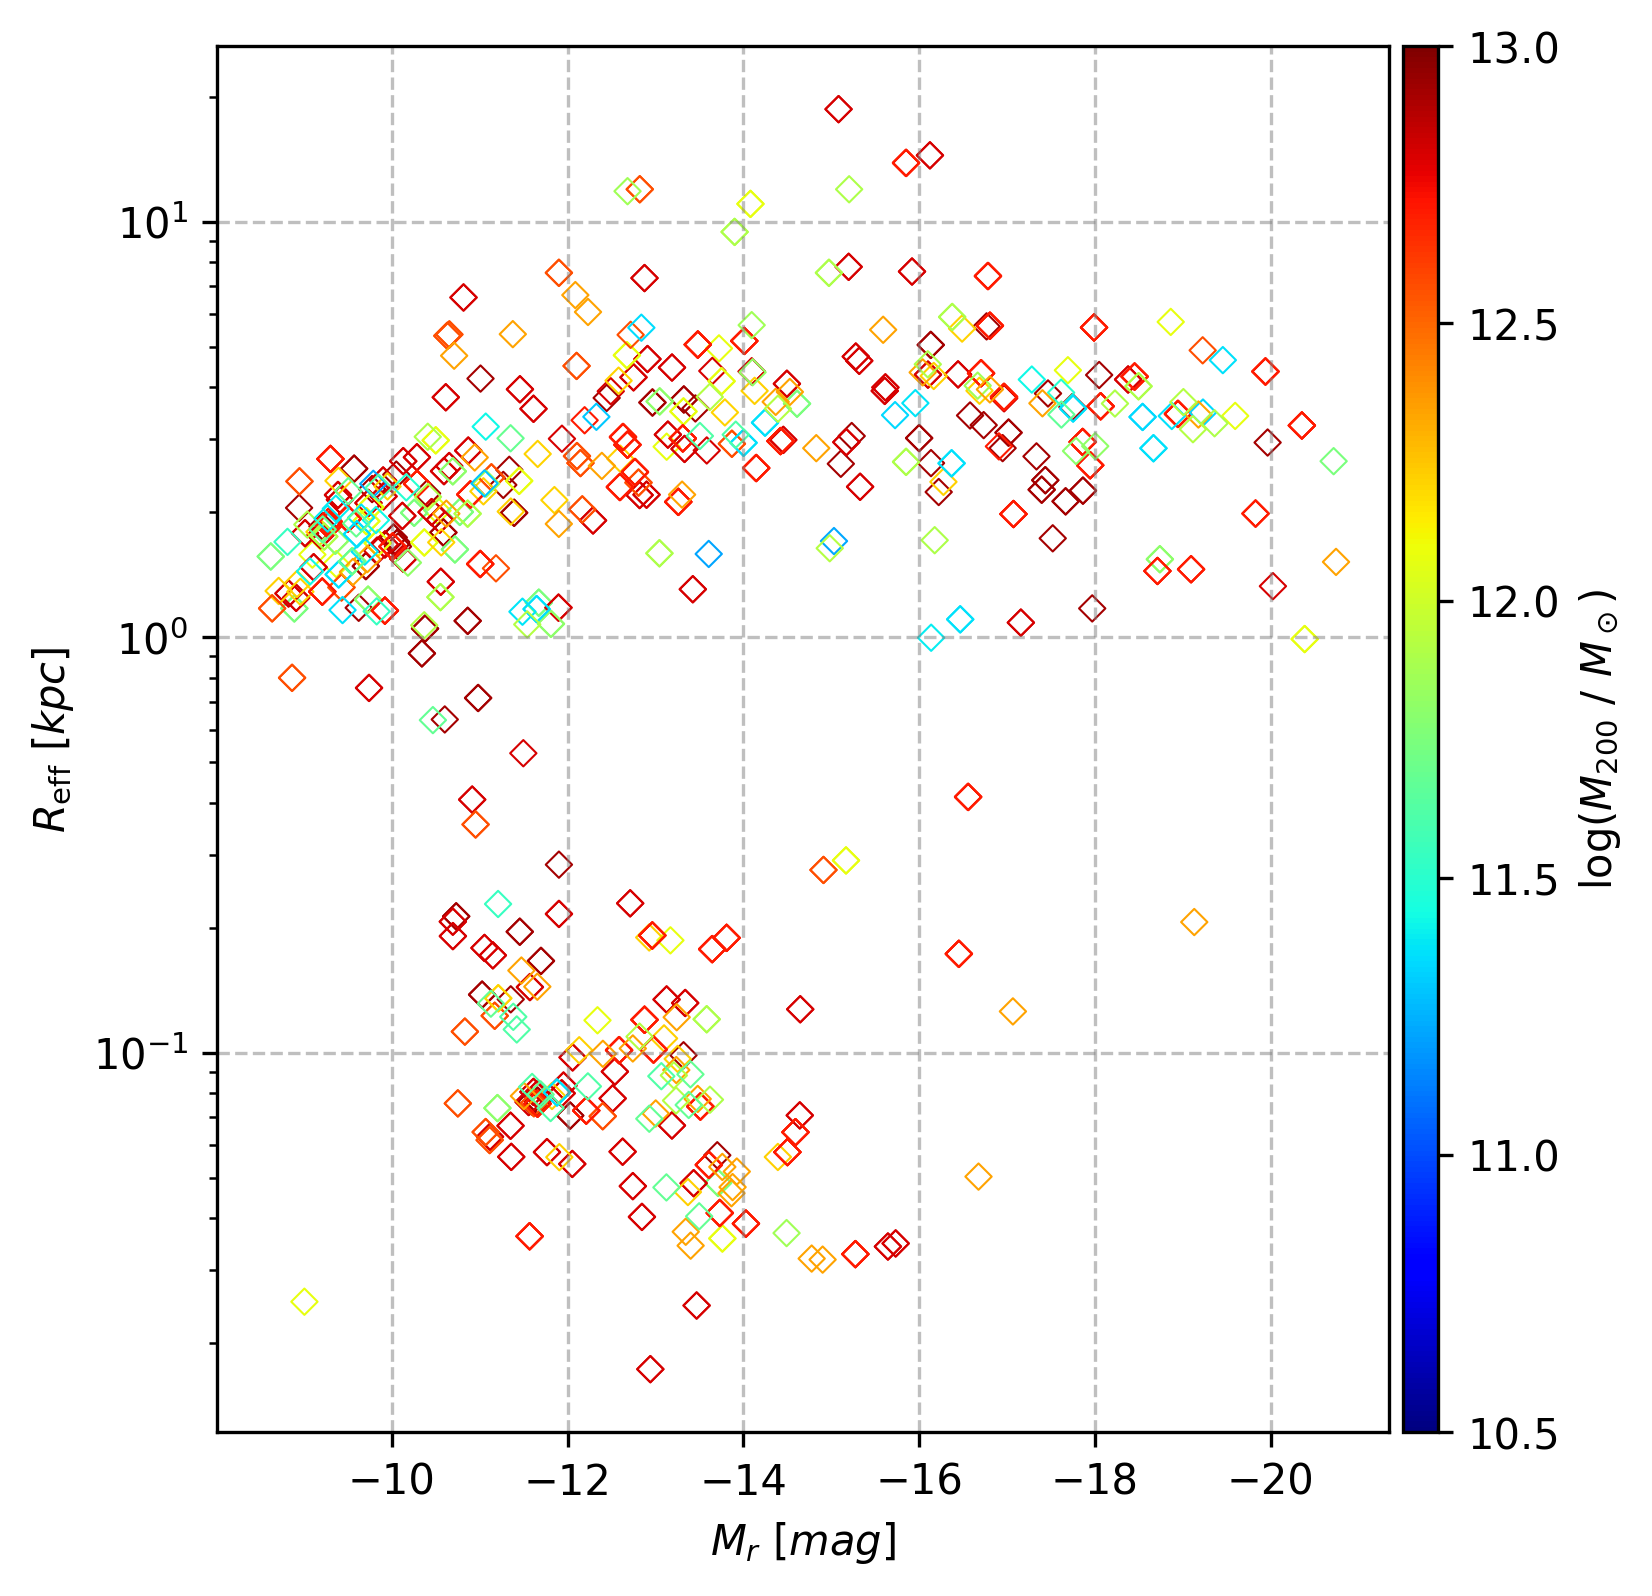

In [104]:
cmap = plt.cm.jet
norm = plt.Normalize(vmin=10.5, vmax=13)

fig, ax = plt.subplots(dpi=300, figsize=(6, 6))

ax.grid(ls='--', c='gray', alpha=0.5)
for key in LG.keys():
    group = LG[key]
    BGG = group['BGG']
    isats = group['sats']
    ax.scatter(
        -2.5*np.log10(isats['r_r50r']), isats['r50r']/snap.unit['kpc'],
        marker='D', s=20,
        facecolor='none', edgecolor=cmap(norm(np.log10(BGG['m200']))),
        lw=0.5)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.01, aspect=40)
cbar.set_label(r'$\log( M_{\rm 200}\ /\ M_\odot )$')


# ax.set_xscale('log')
ax.invert_xaxis()
ax.set_yscale('log')
ax.set_xlabel(r'$M_{r}\ [mag]$')
ax.set_ylabel(r'$R_{\rm eff}\ [kpc]$')

# QF

In [88]:
ssfr_cut = 1 / 6 / snap.age / 1e9

In [120]:
sats.shape

(799,)

Text(0, 0.5, 'SFR$\\ [M_\\odot yr^{-1}]$')

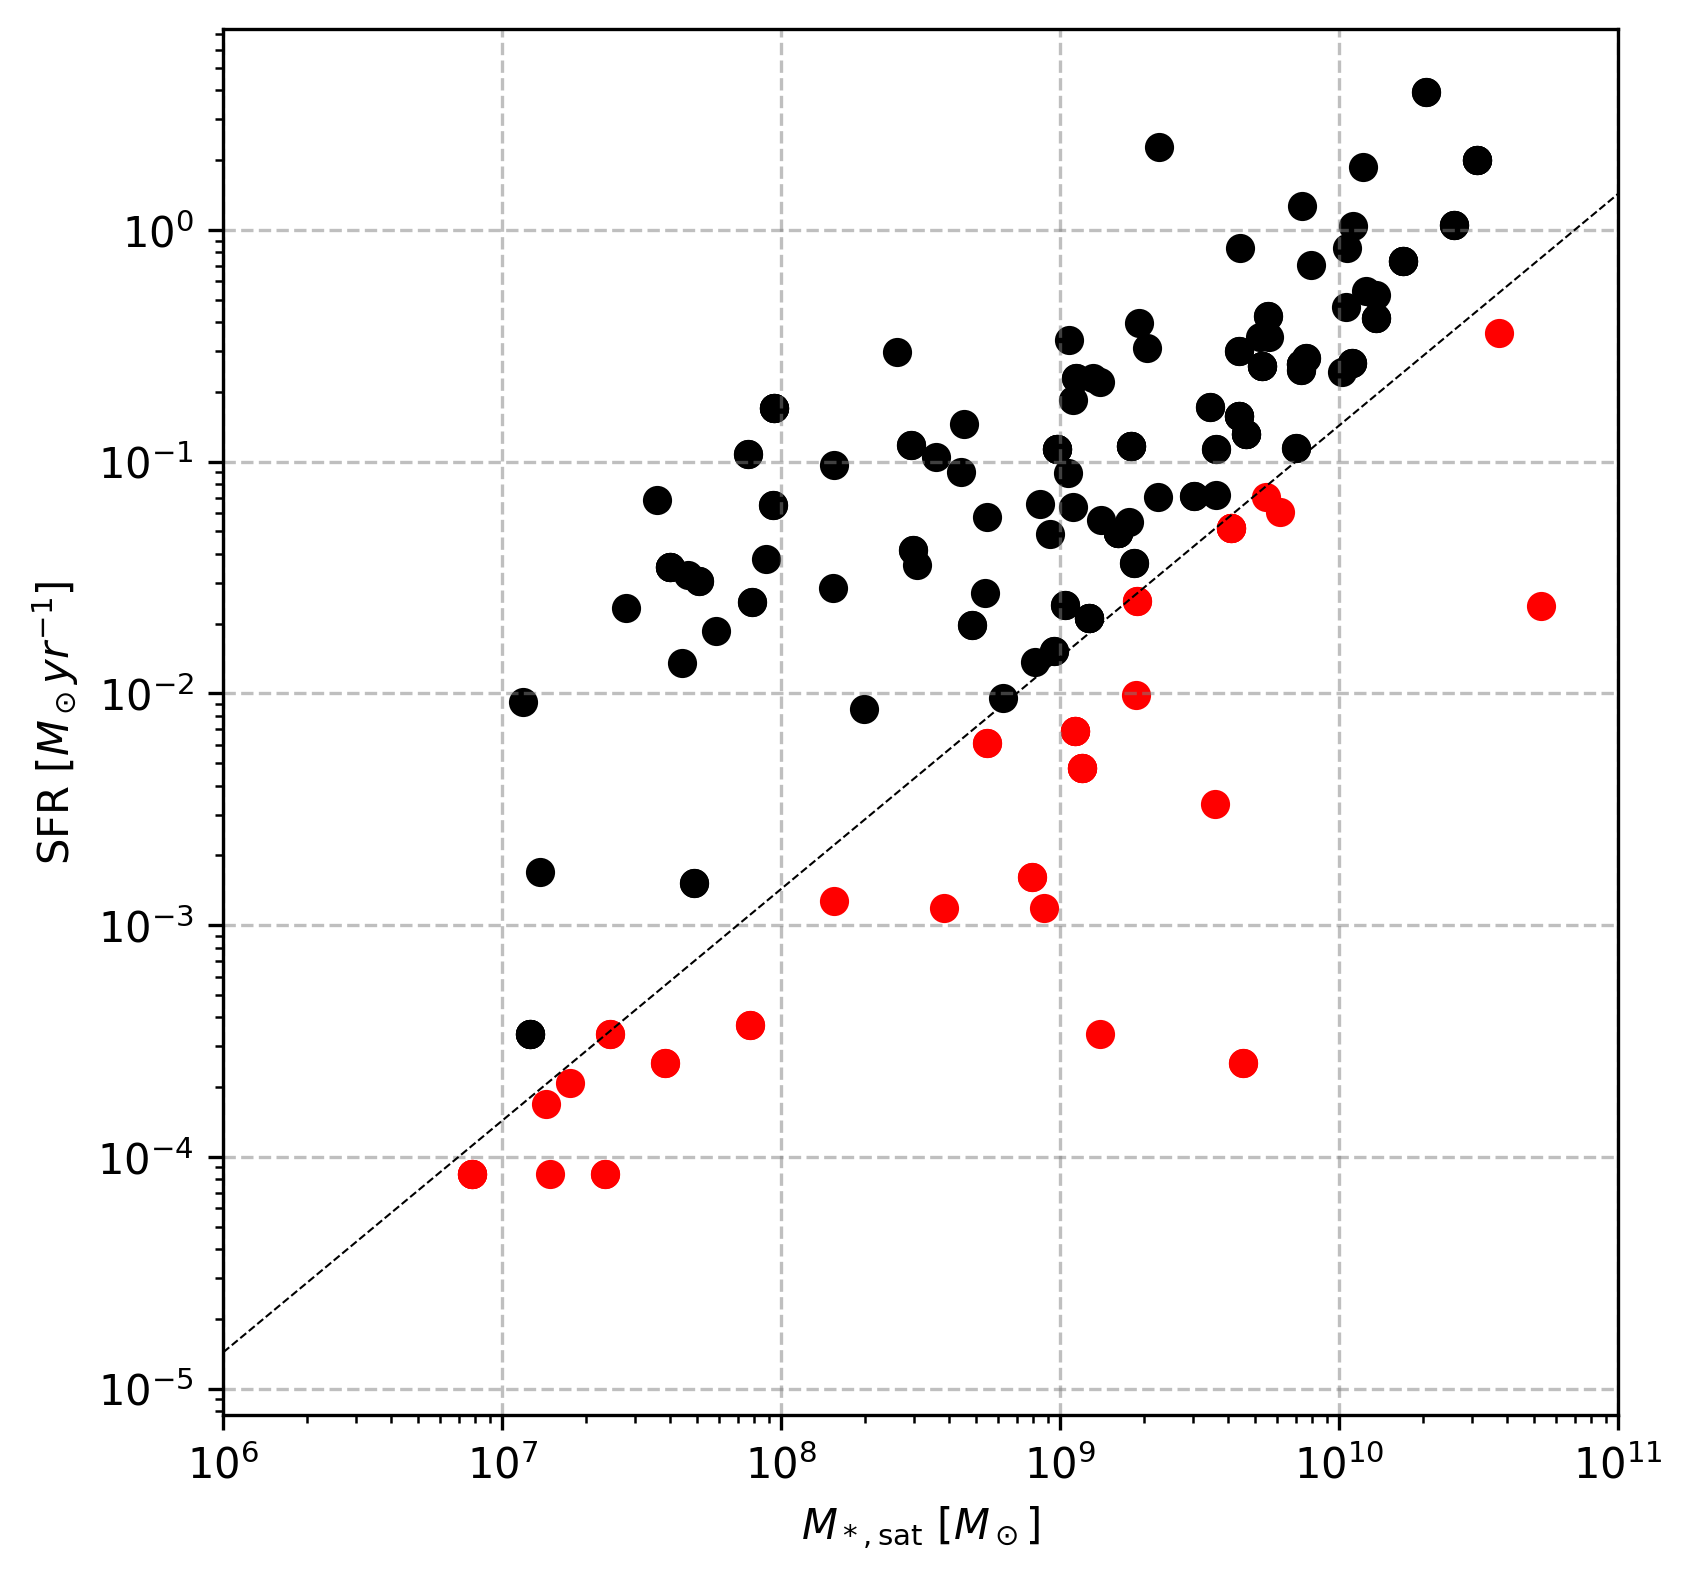

In [89]:
fig, ax = plt.subplots(dpi=300, figsize=(6, 6))
ax.grid(ls='--', c='gray', alpha=0.5)


# Quenched cut line
xs = np.logspace(6, 11, 10)
ys = ssfr_cut * xs
ax.plot( xs,ys, ls='--', c='k', lw=0.5)

ind = sats['m'] * ssfr_cut < sats['SFR_mem']
ax.scatter(sats['m'][ind], sats['SFR_mem'][ind], color='k')
ax.scatter(sats['m'][~ind], sats['SFR_mem'][~ind], color='r')

ax.set_xlim(1e6, 1e11)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M_{\rm *,sat}\ [M_\odot]$')
ax.set_ylabel(r'SFR$\ [M_\odot yr^{-1}]$')

In [90]:
sats.dtype

dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('sigma_bulge', '<f8'), ('m_bulge', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('halo_id', '<i4'), ('halo_nparts', '<i4'), ('halo_level', '<i4'), ('halo_host', '<i4'), ('halo_hostsub', '<i4'), ('halo_x', '<f8'), ('halo_y', '<f8'), ('halo_z', '<f8'), ('halo_vx', '<f8'), ('halo_vy', '<f8'), ('halo_vz', '<f8'), ('halo_mvir', '<f8'), ('halo_rvir', '<f8'), ('fcontam', '<f8'), ('dist', '<f8'), ('central', '?'), ('main', '?'), ('Host', '<i4'), ('r50m', '<f8'), ('r90m', '<f8'), ('r50r

In [91]:
1 / 6 / snap.age / 1e9

1.4338118691117342e-11

Text(0, 0.5, 'Quenched Fraction')

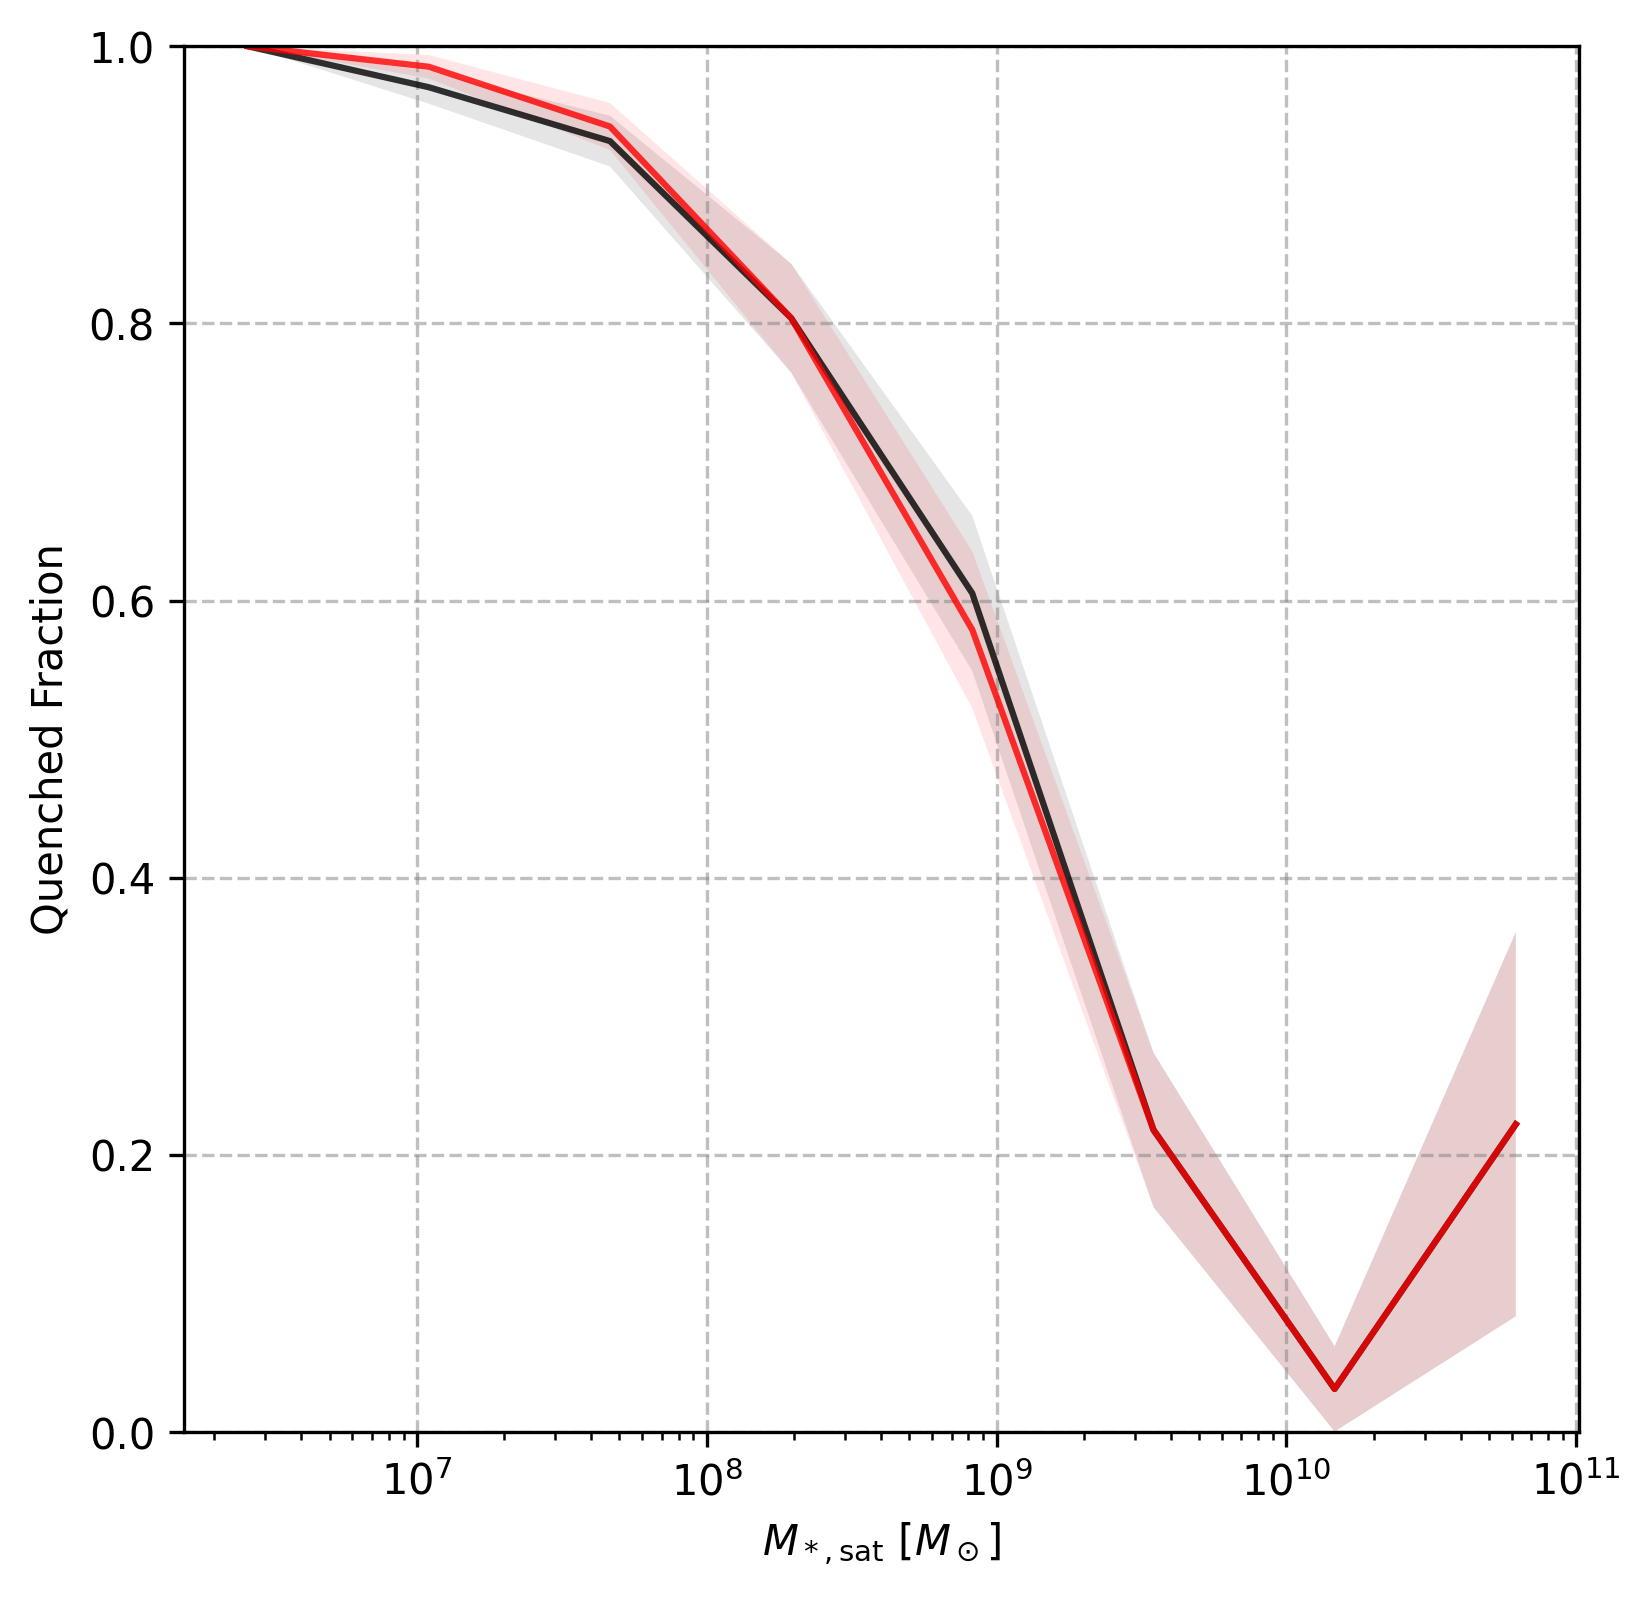

In [92]:
fig, ax = plt.subplots(dpi=300, figsize=(6, 6))
ax.grid(ls='--', c='gray', alpha=0.5)
bins = np.logspace(6,11,9)



qfs = np.zeros(len(bins)-1)
qferrs = np.zeros(len(bins)-1)
for i in range(len(bins)-1):
    sample = sats[(sats['m'] >= bins[i])&(sats['m'] < bins[i+1])]
    ssfr = sample['SFR_mem']/sample['m']
    qf = np.sum(ssfr < ssfr_cut) / len(ssfr)
    qferr = np.sqrt(qf*(1-qf)/len(ssfr))
    qfs[i] = qf
    qferrs[i] = qferr
ax.plot( 0.5*(bins[:-1]+bins[1:]), qfs, color='k', label='Member' if(i==0) else None, alpha=0.8)
ax.fill_between( 0.5*(bins[:-1]+bins[1:]), qfs-qferrs, qfs+qferrs, edgecolor='none',facecolor='k', alpha=0.1)

qfs = np.zeros(len(bins)-1)
qferrs = np.zeros(len(bins)-1)
for i in range(len(bins)-1):
    sample = sats[(sats['m'] >= bins[i])&(sats['m'] < bins[i+1])]
    ssfr = sample['SFR_r90m']/sample['m']
    qf = np.sum(ssfr < ssfr_cut) / len(ssfr)
    qferr = np.sqrt(qf*(1-qf)/len(ssfr))
    qfs[i] = qf
    qferrs[i] = qferr
ax.plot( 0.5*(bins[:-1]+bins[1:]), qfs, color='r', label='R90(mass)' if(i==0) else None, alpha=0.8)
ax.fill_between( 0.5*(bins[:-1]+bins[1:]), qfs-qferrs, qfs+qferrs, edgecolor='none',facecolor='r', alpha=0.1)


ax.set_ylim(0,1)
ax.set_xscale('log')
ax.set_xlabel(r'$M_{\rm *,sat}\ [M_\odot]$')
ax.set_ylabel('Quenched Fraction')

In [93]:
len(subs)

2991